In [1]:
%load_ext autoreload
%autoreload 2

import os
import sys
import time
import random
import pandas as pd
import yaml

from argparse import Namespace

import numpy as np
import networkx as nx
import seaborn as sns
sns.set_style("whitegrid", {'axes.grid' : False})

root_dir = os.path.dirname(
        os.path.dirname(os.path.realpath(".")))

sys.path.append(root_dir)


import logging

from rl_envs_forge.envs.grid_world.grid_world import GridWorld
from common.src.distribution_src import ( 
                                         make_env, 
                                        randomize_walls_positions, 
                                        generate_train_test_split_with_valid_path,
                                        run_distribution_correction_experiment
                                        )
from common.src.simple_dqn_agent import AgentDQN

from common.src.experiment_utils import (
    setup_logger,
    namespace_to_dict,
)

from argparse import Namespace

C:\Users\Chainsword\AppData\Local\Temp\ipykernel_19596\881903052.py:8: DeprecationWarning: 
Pyarrow will become a required dependency of pandas in the next major release of pandas (pandas 3.0),
(to allow more performant data types, such as the Arrow string type, and better interoperability with other libraries)
but was not found to be installed on your system.
If this would cause problems for you,
please provide us feedback at https://github.com/pandas-dev/pandas/issues/54466
        
  import pandas as pd


[(2, 0), (1, 2)]


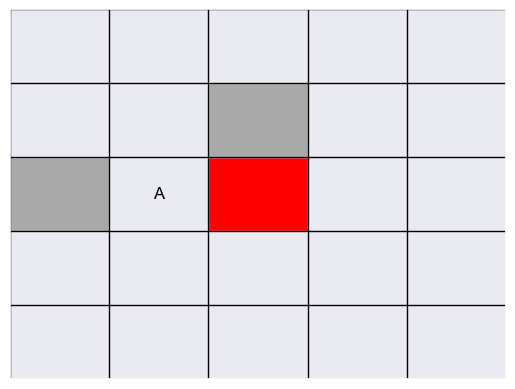

In [2]:
terminal_states = {(2, 2): 1}
start_state = (2, 1)
rows = 5
cols = 5
seed = 2

# random_walls = randomize_walls_positions(rows, cols, start_state, terminal_states, 0.2, seed=seed)
random_walls = [(2, 0), (1, 2)]
print(random_walls)
env = make_env(
    rows,
    cols,
    start_state=start_state,
    p_success=1,
    terminal_states=terminal_states,
    seed=seed,
    walls=random_walls,
)
env.render()

In [3]:
def get_observation_space_shape(observation_space):
    """ Extract a shape-like tuple from a tuple of discrete spaces. """
    return tuple(space.n for space in observation_space.spaces)

In [4]:
env.observation_space

Tuple(Discrete(5), Discrete(5))

In [5]:
env.state

(2, 1)

In [6]:
def state_to_matrix(state, env):
    import numpy as np

    # Extract the environment size from walls and terminal states
    max_rows = env.rows
    max_cols = env.cols
    
    # Create the matrix
    matrix = np.zeros((max_rows, max_cols), dtype=int)
    
    # Mark walls in the matrix
    for wall in env.walls:
        matrix[wall[0], wall[1]] = 1  # Use 1 to indicate walls
    
    # Mark terminal states in the matrix
    for terminal, value in env.terminal_states.items():
        matrix[terminal[0], terminal[1]] = 2 
    
    pos = state
    matrix[pos[0], pos[1]] = 3  # Use 3 to indicate the agent's position
    
    return matrix

state_to_matrix(env.state, env)

array([[0, 0, 0, 0, 0],
       [0, 0, 1, 0, 0],
       [1, 3, 2, 0, 0],
       [0, 0, 0, 0, 0],
       [0, 0, 0, 0, 0]])

In [7]:
state_shape = get_observation_space_shape(env.observation_space)
state_shape

(5, 5)

In [8]:
# env.mdp

In [9]:
# ts = next(iter(terminal_states))

# for trial in range(100000):
#     random_walls = randomize_walls_positions(rows, cols, start_state, terminal_states, 0.2, seed=trial)

#     if (start_state in random_walls) or (ts in random_walls):
#         raise ValueError("start state or terminal state in walls")

    

In [10]:
transitions_list = [(key[0], key[1], *value[0]) for key, value in env.mdp.items()]

transitions_train, transitions_val = generate_train_test_split_with_valid_path(
        transitions_list=transitions_list,
        start_state=start_state,
        terminal_states=terminal_states,
)
        

In [11]:
### Load up a config

file_path = r'D:\Work\repos\phd-research\experiments\dqn\results\2024May17-105508_configs\0000_algorithm_default\0\cfg.yaml'

# Open the YAML file and load its content into a dictionary
with open(file_path, 'r') as file:
    data = yaml.safe_load(file)
    
opts = Namespace(**data)

logger = setup_logger(
        opts.full_title
    )

opts.seed = random.randint(0, 2**32 - 1) if opts.seed is None else opts.seed
opts_dict = namespace_to_dict(opts)
# opts_dict = vars(opts)

opts_dict

{'agent_params': {'agent': 'AgentDQN',
  'args_': {'batch_size': 32,
   'epsilon': {'decay': 250000, 'end': 0.01, 'start': 1.0},
   'gamma': 0.9,
   'loss_fcn': 'mse_loss',
   'replay_start_size': 50,
   'target_model_update_freq': 40,
   'train_step_cnt': 500,
   'training_freq': 4,
   'validation_enabled': False,
   'validation_epsilon': 0.001,
   'validation_step_cnt': 250}},
 'algorithm': 'default',
 'cfg_id': 0,
 'cols': 10,
 'experiment': 'experiment_distributions',
 'experiment_arguments': {'algorithm': 'default'},
 'full_title': '2024May17-105508_configs_algorithm=default',
 'neural_fit_mode': 'max',
 'num_steps': 40000,
 'optim': {'args_': {'eps': 0.0003125, 'lr': 0.1}, 'name': 'Adam'},
 'out_dir': '.\\results\\2024May17-105508_configs\\0000_algorithm_default\\0',
 'p_success': 1,
 'replay_buffer': {'action_dim': 1, 'max_size': 1000, 'n_step': 0},
 'rows': 10,
 'run_id': 0,
 'seed': 3261333208,
 'start_state': (1, 1),
 'terminal_states': {(8, 8): 1.0},
 'title': 'algorithm=def

In [12]:
opts

Namespace(agent_params={'agent': 'AgentDQN', 'args_': {'batch_size': 32, 'epsilon': {'decay': 250000, 'end': 0.01, 'start': 1.0}, 'gamma': 0.9, 'loss_fcn': 'mse_loss', 'replay_start_size': 50, 'target_model_update_freq': 40, 'train_step_cnt': 500, 'training_freq': 4, 'validation_enabled': False, 'validation_epsilon': 0.001, 'validation_step_cnt': 250}}, algorithm='default', cfg_id=0, cols=10, experiment='experiment_distributions', experiment_arguments={'algorithm': 'default'}, full_title='2024May17-105508_configs_algorithm=default', neural_fit_mode='max', num_steps=40000, optim={'args_': {'eps': 0.0003125, 'lr': 0.1}, 'name': 'Adam'}, out_dir='.\\results\\2024May17-105508_configs\\0000_algorithm_default\\0', p_success=1, replay_buffer={'action_dim': 1, 'max_size': 1000, 'n_step': 0}, rows=10, run_id=0, seed=3261333208, start_state='(1, 1)', terminal_states={'(8, 8)': 1.0}, title='algorithm=default', train_max_iterations=30)

In [13]:
opts_dict["start_state"]

(1, 1)

In [14]:
opts_dict["terminal_states"]

{(8, 8): 1.0}

In [15]:
logger.info(f"Starting experiment: {opts_dict['full_title']}")

rows = opts_dict["rows"]
cols = opts_dict["cols"]
start_state = opts_dict["start_state"]
p_success = opts_dict["p_success"]
terminal_states = opts_dict["terminal_states"]
run_id = opts_dict["run_id"]

### Setup environments ###
train_env = make_env(rows, cols, start_state, p_success, terminal_states, run_id)
validation_env = make_env(rows, cols, start_state, p_success, terminal_states, run_id)

### Setup output and loading paths ###

experiment_agent = AgentDQN(
    train_env=train_env,
    validation_env=validation_env,
    experiment_output_folder=opts_dict["out_dir"],
    experiment_name=opts_dict["experiment"],
    resume_training_path=None,
    save_checkpoints=True,
    logger=logger,
    config=opts_dict,
)

# experiment_agent.train(3)

2024-05-19 17:51:26,768 - 2024May17-105508_configs_algorithm=default - INFO - Starting experiment: 2024May17-105508_configs_algorithm=default
2024-05-19 17:51:26,774 - 2024May17-105508_configs_algorithm=default - INFO - Loaded configuration settings.
2024-05-19 17:51:27,315 - 2024May17-105508_configs_algorithm=default - INFO - Initialized newtworks and optimizer.


In [16]:
train_env.terminal_states

{(8, 8): 1.0}

In [17]:
def randomly_step_through_env(env):
    is_terminated = False
    truncated = False
    visited_states = set()
    recorded_states = []

    while not is_terminated and not truncated:
        # Sample a random action from the action space
        action = env.action_space.sample()
        
        # Take a step in the environment
        s_prime, reward, is_terminated, truncated, info = env.step(action)
        
        # Convert state to a hashable type (e.g., tuple) if it's not already
        s_prime_hashable = tuple(s_prime) if isinstance(s_prime, (list, np.ndarray)) else s_prime
        
        # Check if the state is new
        if s_prime_hashable not in visited_states:
            visited_states.add(s_prime_hashable)
            recorded_states.append(s_prime)
            print(f"New State: {s_prime}, Action: {action}, Reward: {reward}, Terminated: {is_terminated}, Truncated: {truncated}, Info: {info}")

    print("Reached terminal state or truncated.")
    return recorded_states

# Example usage:
# Assuming `train_env` is your environment instance
randomly_step_through_env(train_env)

New State: (1, 2), Action: 1, Reward: 0, Terminated: False, Truncated: False, Info: {}
New State: (0, 2), Action: 0, Reward: 0, Terminated: False, Truncated: False, Info: {}
New State: (0, 1), Action: 3, Reward: 0, Terminated: False, Truncated: False, Info: {}
New State: (1, 1), Action: 2, Reward: 0, Terminated: False, Truncated: False, Info: {}
New State: (0, 3), Action: 1, Reward: 0, Terminated: False, Truncated: False, Info: {}
New State: (2, 2), Action: 2, Reward: 0, Terminated: False, Truncated: False, Info: {}
New State: (3, 2), Action: 2, Reward: 0, Terminated: False, Truncated: False, Info: {}
New State: (3, 3), Action: 1, Reward: 0, Terminated: False, Truncated: False, Info: {}
New State: (2, 3), Action: 0, Reward: 0, Terminated: False, Truncated: False, Info: {}
New State: (1, 3), Action: 0, Reward: 0, Terminated: False, Truncated: False, Info: {}
New State: (1, 4), Action: 1, Reward: 0, Terminated: False, Truncated: False, Info: {}
New State: (2, 4), Action: 1, Reward: 0, Te

[(1, 2),
 (0, 2),
 (0, 1),
 (1, 1),
 (0, 3),
 (2, 2),
 (3, 2),
 (3, 3),
 (2, 3),
 (1, 3),
 (1, 4),
 (2, 4),
 (3, 4),
 (3, 1),
 (4, 1),
 (4, 0),
 (4, 2),
 (5, 2),
 (5, 1),
 (6, 1),
 (6, 2),
 (7, 2),
 (8, 2),
 (8, 3),
 (9, 3),
 (7, 3),
 (6, 3),
 (6, 4),
 (7, 4),
 (5, 4),
 (2, 1),
 (3, 0),
 (5, 0),
 (6, 0),
 (7, 0),
 (8, 0),
 (9, 0),
 (9, 1),
 (7, 1),
 (8, 1),
 (0, 4),
 (2, 5),
 (3, 5),
 (2, 6),
 (2, 7),
 (2, 8),
 (3, 8),
 (3, 9),
 (2, 9),
 (1, 7),
 (3, 7),
 (1, 8),
 (0, 8),
 (0, 7),
 (1, 6),
 (1, 5),
 (3, 6),
 (4, 6),
 (4, 5),
 (4, 4),
 (4, 3),
 (9, 2),
 (9, 4),
 (9, 5),
 (8, 5),
 (8, 6),
 (8, 4),
 (8, 7),
 (7, 7),
 (8, 8)]

In [18]:
# loss_records, bm_error = run_distribution_correction_experiment(
#         tau=opts.tau,
#         seed=opts.seed,
#         run_id=opts.run_id,
#         rows=opts.rows,
#         cols=opts.cols,
#         start_state=opts.start_state,
#         p_success=opts.p_success,
#         terminal_states=opts.terminal_states,
#         num_steps=opts.num_steps,
#         gamma=opts.gamma,
#         min_samples=opts.min_samples,
#         batch_size=opts.batch_size,
#         train_max_iterations=opts.train_max_iterations,
#         neural_fit_mode=opts.neural_fit_mode,
#         algorithm=opts.algorithm,
#         logger=logger,
#     )

In [19]:
# loss_records